# Fetching observations from MET data base services

This notebook serves as sandbox for fetching data from frost.met, havvarsel-frost.met and thredds.met

See https://api.met.no/ for all interfaces and possible sources!!


## Havvarsel frost
Havvarsel frost delivers so far `temperature` measurements originated from badevann.no at seven beaches in the south of Norway (glider data integrated in the meantime, but not yet used here!). 
> Documentation:
> - API documentation for obs/badevann https://havvarsel-frost.met.no/docs/apiref#/obs%2Fbadevann/obsBadevannGet 
> - Datastructure described on https://havvarsel-frost.met.no/docs/dataset_badevann




In [1]:
# Importing general libraries
import sys
import json
import datetime
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import netCDF4
import pyproj

### Example to fetch time series

In [2]:
start_time = datetime.datetime.strptime("2010-10-01T00:00", "%Y-%m-%dT%H:%M")
end_time = datetime.datetime.strptime(datetime.datetime.now().isoformat(timespec='minutes'), "%Y-%m-%dT%H:%M")


In [3]:
frost_api_base="https://havvarsel-frost.met.no"
endpoint = frost_api_base + "/api/v1/obs/badevann/get"

payload = {'time': str(start_time.isoformat()) + "Z/" + str(end_time.isoformat()) + "Z", 
                    'incobs':'true', 'buoyids': "003", 'parameter':'temperature'}
# the havvarsel-frost API uses colon in the url and does not replace them with ASCI what is default
payload_str = "&".join("%s=%s" % (k,v) for k,v in payload.items())

In [4]:
try:
    r = requests.get(endpoint, params=payload_str)
    print("Trying " + r.url)
    r.raise_for_status()
except requests.exceptions.HTTPError as err:
    raise Exception(err)


Trying https://havvarsel-frost.met.no/api/v1/obs/badevann/get?time=2010-10-01T00:00:00Z/2022-05-04T12:38:00Z&incobs=true&buoyids=003&parameter=temperature


In [5]:
r.json()["data"]["tseries"][0]["observations"][-1]["time"]

'2020-09-15T07:03:00Z'

### Explore available data

Note that the availability of data depends on the selected dates!

In [6]:
badevann_df = pd.DataFrame(columns=['buoyid', 'name', 'lat', 'lon', 'source', 'N_obs', 'first_obs', 'last_obs'])

frost_api_base="https://havvarsel-frost.met.no"
endpoint = frost_api_base + "/api/v1/obs/badevann/get"

r = requests.get(endpoint)
print("Trying " + r.url)
r.raise_for_status()

badevann_df = pd.DataFrame(columns=['buoyid', 'name', 'lat', 'lon'])
for i in range(len(r.json()["data"]["tseries"])):
    buoyid = r.json()["data"]["tseries"][i]["header"]["id"]["buoyid"]
    source = r.json()["data"]["tseries"][i]["header"]["id"]["source"]
    name = r.json()["data"]["tseries"][i]["header"]["extra"]["name"]
    lat = r.json()["data"]["tseries"][i]["header"]["extra"]["pos"]["lat"]
    lon = r.json()["data"]["tseries"][i]["header"]["extra"]["pos"]["lon"]

    payload = {'time': str(start_time.isoformat()) + "Z/" + str(end_time.isoformat()) + "Z", 
                    'incobs':'true', 'buoyids': buoyid, 'parameter':'temperature'}
    payload_str = "&".join("%s=%s" % (k,v) for k,v in payload.items())
    try:
        r_ts = requests.get(endpoint, params=payload_str)
        N_obs = len(r_ts.json()["data"]["tseries"][0]["observations"])
        first_obs = r_ts.json()["data"]["tseries"][0]["observations"][0]["time"][0:10]
        last_obs = r_ts.json()["data"]["tseries"][0]["observations"][-1]["time"][0:10]
    except:
        N_obs = 0
    if N_obs >= 100:
        badevann_df = badevann_df.append({"buoyid" : buoyid, "name" : name, "lat" : float(lat), 
            "lon" : float(lon), "source" : source, "N_obs" : int(N_obs), 
            "first_obs": first_obs, "last_obs":last_obs}, ignore_index=True)

badevann_df = badevann_df.astype({"N_obs":int})

Trying https://havvarsel-frost.met.no/api/v1/obs/badevann/get


In [18]:
badevann_df

,buoyid,name,lat,lon,N_obs,first_obs,last_obs,source
6,127,Bortelidtjønna,58.818906,7.471262,4009,2021-07-02,2021-10-18,badetassen.no
10,34,Sota fjordpark,59.726017,10.256319,3684,2019-06-24,2022-04-06,badetassen.no
18,44,Svingen,59.557590,9.207190,13054,2019-07-04,2021-09-20,badetassen.no
20,76,Rambekkvika,60.781230,10.702680,10340,2020-06-18,2021-09-21,badetassen.no
22,103,Eivindsvatnet,59.419217,5.300414,10382,2020-07-02,2021-11-29,badetassen.no
...,...,...,...,...,...,...,...,...
485,29,Stordammen,59.719522,10.128980,1570,2019-06-24,2021-06-29,badetassen.no
493,87,Vik,60.466249,7.066029,12477,2020-06-17,2022-04-25,badetassen.no
508,1-7246,Langedalsvannet,58.259640,8.404470,14,2020-07-24,2021-10-09,Lillesand kommune
509,51,Kråkeskarvet,60.473128,7.075648,13559,2019-07-08,2021-11-08,badetassen.no


In [19]:
badevann_df.to_csv("badevann-buoys.csv", sep=",", index=False)

See the output file for information about all buoys!

### Explore professional buoys in map

(Not yr.no-manual observations)

In [20]:
badevann_df = badevann_df[badevann_df["source"]!="yr.no"]

In [21]:
N = badevann_df.shape[0]
lon = np.array(badevann_df["lon"],dtype=float)
lat = np.array(badevann_df["lat"],dtype=float)
buoyid = np.array(badevann_df["buoyid"],dtype=str)


In [22]:
nc = netCDF4.MFDataset(['https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2021100100.nc']) #an example file 

proj = pyproj.Proj(nc["projection_stere"].proj4)

lons = nc["lon"][:].data
lats = nc["lat"][:].data

In [23]:
def latlon2cell(lat_mesh, lon_mesh, lat, lon):
    distances = (lat_mesh-lat)**2 + (lon_mesh-lon)**2 
    return np.unravel_index(distances.argmin(), distances.shape)

def latlonPROJcell(proj, lat, lon):
    x, y = proj(lon,lat,inverse=False)
    x = x/800
    y = y/800
    return x, y

In [24]:
xys = np.zeros((lon.shape[0],2))
for buoy in range(lon.shape[0]): 
    xys[buoy,0], xys[buoy,1] = latlonPROJcell(proj, lat[buoy], lon[buoy])

In [25]:
h = nc["h"][:].data
land_value = h.min()
land = np.ma.masked_where(h == land_value, h)

In [32]:
def plot_sites(land, xys, buoyid, subarea=None):
    "subarea = [x0 x1 y0 y1]"    
    if subarea is None:
        subarea = [0, land.shape[1], 0, land.shape[0]]
    buoy_subarea = np.logical_and(np.all(xys < [subarea[1],subarea[3]], axis=1), np.all(xys > [subarea[0],subarea[2]], axis=1))

    fig, ax = plt.subplots(1,1,figsize=(40,15))
    ax.imshow(land[subarea[2]:subarea[3],subarea[0]:subarea[1]], cmap='ocean', origin="lower")
    ax.scatter(xys[buoy_subarea,0]-subarea[0], xys[buoy_subarea,1]-subarea[2], c='r', marker='x')
    for i, txt in enumerate(buoyid[buoy_subarea]):
        ax.annotate(str(txt), (xys[np.arange(N)[buoy_subarea][i],0]-subarea[0], xys[np.arange(N)[buoy_subarea][i],1]-subarea[2]))

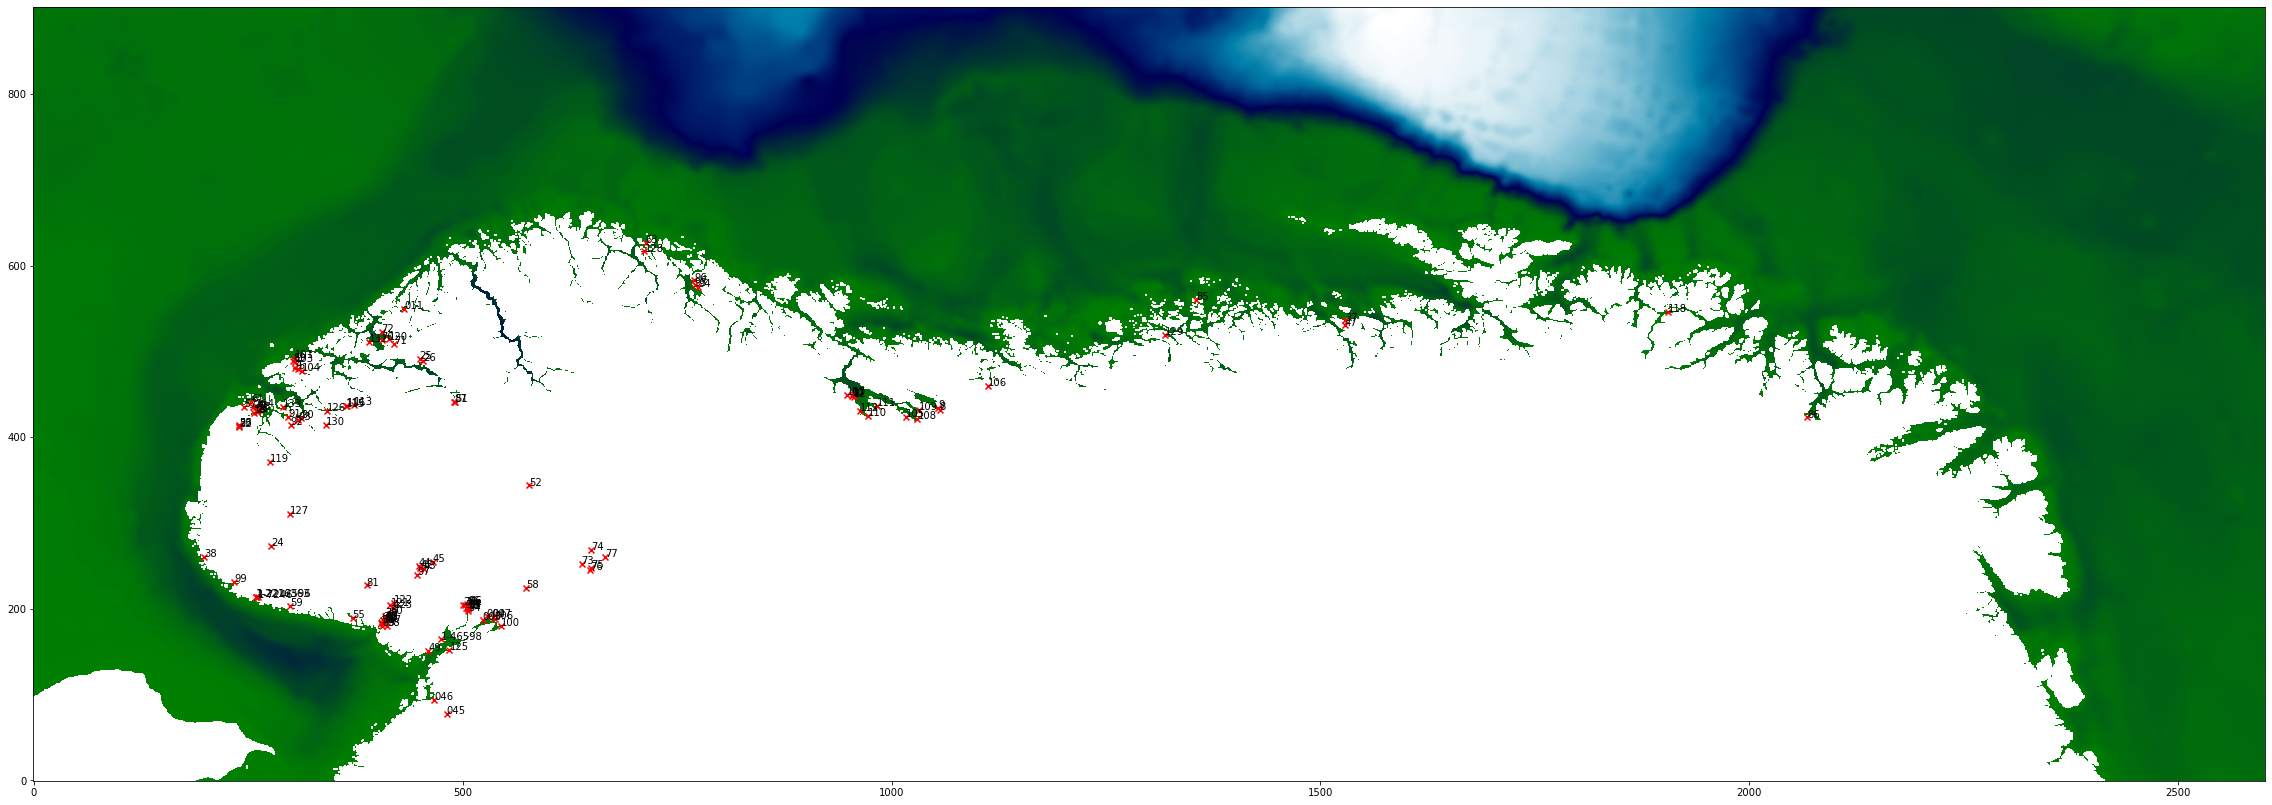

In [33]:
plot_sites(land, xys, buoyid)

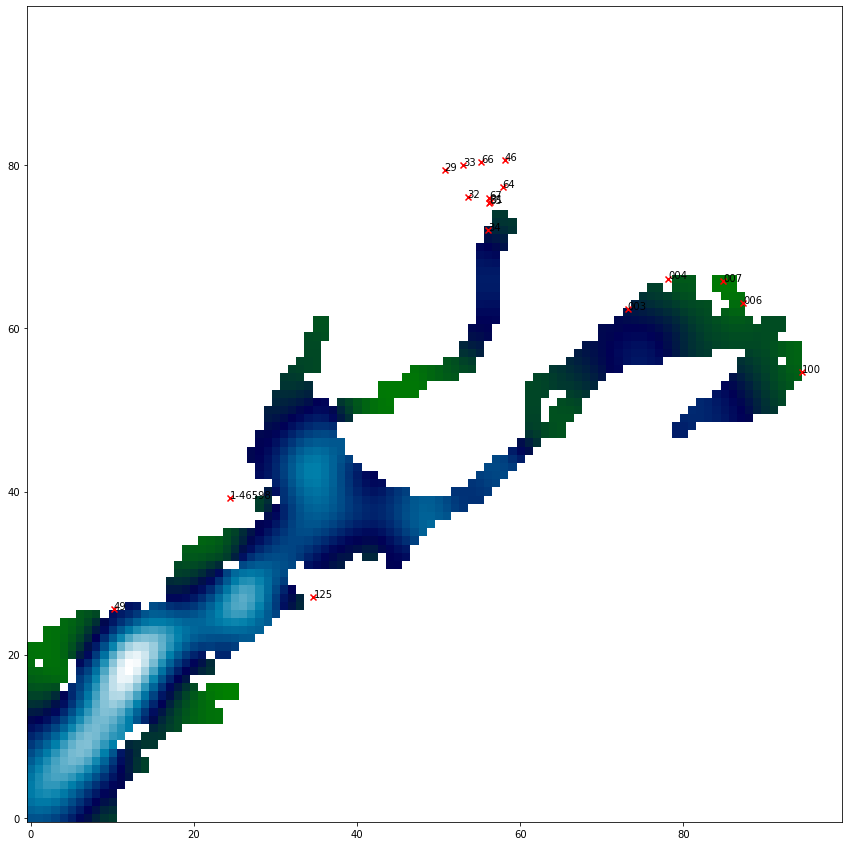

In [34]:
plot_sites(land, xys, buoyid, subarea=[450,550,125,225])